- Basic setup to simulate trajectories with 3 parameters (drift, bound, starting point) using Euler Mayurama  method
	- Obtain histograms and psychometrics
	- Compare to analytic solutions, explore the error of the approximation with dt
	- Explore dependence of histograms and psychometrics with parameter values
- Add time varying bound, variability in parameters
- Explore race models

- "Optogenetic manipulations"
	- "Sensory neurons" vs "Integrator neurons"
	- Bound "deletion"
        - Other ways?

- History effects
	- Explore updates on starting point and drifts
	- Also post error slowing (increase bounds after errors)

In [1]:
# @title Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
import importlib
import random
from scipy.optimize import curve_fit


# import all functions defined in ddm.py
import ddm
import plottingddm as pddm

# set the font size of plots
font = {'size'   : 14}
plt.rc('font', **font)

In [20]:
# Reload all functions from the ddm.py file
# use after making changes in ddm.py.
importlib.reload(ddm)
importlib.reload(pddm)

<module 'plottingddm' from '/Users/marcocolnaghi/Documents/INCDP/Classes/DecisionMaking/indp22-ddm-simulation-project/code/plottingddm.py'>

In [21]:
seed = 2

In [22]:
# Basic Experiment - no opto.

mu = 0.5 # drift
theta = 1 # bound
z = 0 # starting point
sigma = 1 # noise std
b = 0.1 # time varying bound

# Define simulation parameters
n_trials = 1000
dt = .001
T = 10

# theta vector
t = np.arange(0, T, dt)
theta = theta*np.ones((t.size,1))

In [23]:
# Run single Simulation
S, traj = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, seed=seed)

In [24]:
# Properties for Plots
bins = np.linspace(0, 6, 30)
colors = ['#2662E4', '#F02D3A']   # colors for correct/incorrect
colorgradient = ['#49BCCE', '#1396AB', '#000000', '#B664A7', '#F187DE'] # colors for manipulation plots


In [25]:
# Function to downsample the data (run always)

def downsampleTraj(traj, t, dsFactor):
    ds_traj = traj[:,np.arange(0,t.size,dsFactor)]
    ds_t = t[np.arange(0,t.size,dsFactor)] 
    
    return ds_traj, ds_t

In [26]:
# Set downsampling factor to 1 to not ds.
dsFactor = 1
ds_traj, ds_t = downsampleTraj(traj, t, dsFactor)

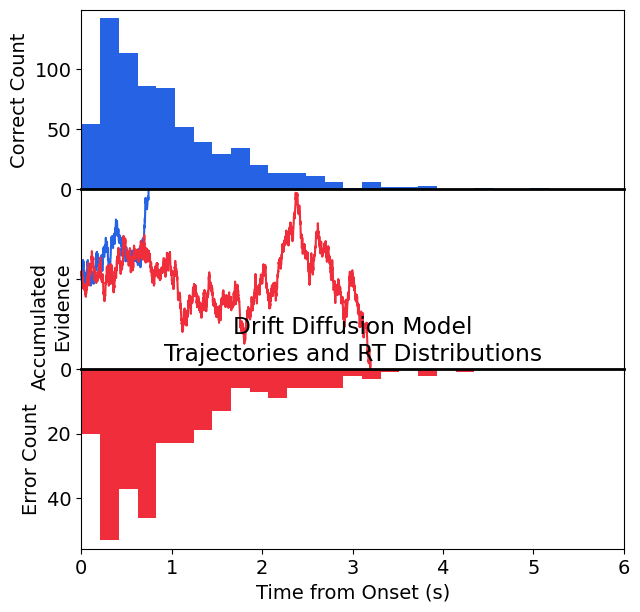

In [27]:
# Plot Trajectories with RT histograms
hits, errs = ddm.calc_hits_errs(S, mu)
fig = pddm.plot_trajectories_and_RT(S, hits, errs, ds_traj, mu, ds_t, bins, colors)
fig.savefig('RTandSingleTraj.png', format='png', dpi=600)


In [ ]:
## Plot Distributions as a function of stuff.


In [ ]:
# Run DDM simulations for different drifts
n_mu = 21
n_z = 5
mu_list = 3*np.linspace(-1, 1, n_mu)
z_list = np.linspace(-0.8, 0.8, n_z)

# Preallocate results
plt.figure(figsize=(5,5))
for idxZ, z in enumerate(z_list):
    S_list = []
    hits_list = []
    errs_list = []  
    for idxMu, mu in enumerate(mu_list):
        z = z_list[idxZ]
        mu = mu_list[idxMu]
        # Simulate trajectories
        S, _ = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, seed=seed)
        S_list.append(S)
        hits, errs = ddm.calc_hits_errs(S, mu)
        hits_list.append(hits)
        errs_list.append(errs)
    
    prob_a = ddm.calc_psychometric(S_list, mu_list)
    pddm.plot_psychometric(prob_a, mu_list, colorgradient[idxZ])
    if z == 0:
        plt.plot(mu_list, prob_a, color='k', linewidth= 2)



In [ ]:
# Plot a psychometric curve
prob_a = ddm.calc_psychometric(S_list, mu_list)
ddm.plot_psychometric(prob_a, mu_list, [0 0 0])
plt.title('Psychometric function for\n a basic drift diffusion model')
plt.show()

In [ ]:
# Define Opto Parameters

In [ ]:
# Optogentic manipulation of the sensory detector, here we change the drift parameter mu

# Define DDM parameters
mu = 2 # drift
theta = 1 # bound
z = 0 # starting point
sigma = 1 # noise std
mfactor = 1
decayingconstant = 2
theta = theta*(np.exp(-t/decayingconstant))

# Define simulation time-parameters
n_trials = 1000
dt = .001
T = 10
t = np.arange(0, T, dt) # simulation time

# Define optogenetic parameters
startT = 0.2
finishT = 0.7
opto_time = np.where(np.logical_and(t >= startT, t <= finishT))[0] # 500 msec stimulation
opto_val = mfactor*mu
mu = mu*np.ones((t.size,1))
mu[opto_time] -= opto_val

# Run simulation
S, traj = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, seed=seed)
ds_traj, ds_t = downsampleTraj(traj, t, 1)

In [ ]:
## Trial Properties
trialID = 1
rangeanim = np.sum(~np.isnan(ds_traj[trialID,:]))

## Graphical Properties
alphas = 0.3*np.ones(t.size)
alphas[opto_time] = 0.6
optocolor = np.zeros(4)
optocolor[0:-1] = [255/255, 167/255, 55/255]
optocolor[3] = alphas[0]
optocolorHEX = np.tile(colors[0], t.size)
optocolorHEX[opto_time] = '#FFA737'

# Start the Plot
fig = plt.figure(figsize=(10,5))
gs = GridSpec(1, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, 0:-1])
ax1 = fig.add_subplot(gs[0, -1], projection='polar')

line, = ax0.plot(ds_t, ds_traj[trialID,:], color=colors[0])
ax0.plot(ds_t, -theta, color='black')
ax0.plot(ds_t, theta, color='black')

optopatch = ax0.fill_between(t[opto_time], -theta[opto_time], theta[opto_time], color=optocolor)
ax0.set_xlabel('Time from Start (s)')
ax0.xaxis.set_label_position('top') 
ax0.set_ylabel('Accumulated Evidence')
ax0.xaxis.tick_top()

muline, = ax1.plot([mu[0], mu[0]], [0,1], linewidth = 3, color='#2662E4')
ax1.set_rmax(1)
ax1.set_rticks([])
ax1.set_xticks(mu[0])
ax1.grid(False)
fig.tight_layout(pad=2.0)
ax1.set_xlabel('realtime mu')

def animate(i, ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX):
    line.set_xdata(ds_t[:i])  # update the data.
    line.set_ydata(ds_traj[trialID,:i])  # update the data.
    line.axes.axis([ds_t[i]-0.4, ds_t[i]+0.2, -1.1, 1.1])
    optocolor[3] = alphas[i]
    optopatch.set_color(optocolor)
    muline.set_xdata([mu[i], mu[i]])
    ax1.set_xticks(mu[i])
    ax1.set_xticklabels(mu[i])
    muline.set_color(optocolorHEX[i])
    return line,


ani = animation.FuncAnimation(
    fig, animate, rangeanim, fargs=[ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX], interval=30, save_count=50)
ani.save('simulation_OptoSensory.gif')
plt.show()

In [ ]:
# Optogentic manipulation of the evidence accumulator, here we change the clamp x

# Define DDM parameters
mu = 2 # drift
theta = 1 # bound
z = 0 # starting point
sigma = 1 # noise std
# mfactor = 1
decayingconstant = 2
theta = theta*(np.exp(-t/decayingconstant))

# Define simulation time-parameters
n_trials = 1000
dt = .001
T = 10
t = np.arange(0, T, dt) # simulation time

# Define optogenetic parameters
startT = 0.2
finishT = 0.7
mu = mu*np.ones((t.size,1))
clamp_time = np.where(np.logical_and(t >= startT, t <= finishT))[0] # 500 msec stimulation
clamp_val = 0*np.ones((clamp_time.size,1))
clamp_x = [clamp_time, clamp_val] # stimulation time, clamp value

# Run simulation
S, traj = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, clamp_x, seed = seed)
ds_traj, ds_t = downsampleTraj(traj, t, 1)

In [ ]:
## Trial Properties
trialID = 1
rangeanim = np.sum(~np.isnan(ds_traj[trialID,:]))

## Graphical Properties
alphas = 0.3*np.ones(t.size)
alphas[opto_time] = 0.6
optocolor = np.zeros(4)
optocolor[0:-1] = [255/255, 167/255, 55/255]
optocolor[3] = alphas[0]
optocolorHEX = np.tile(colors[0], t.size)

# Start the Plot
fig = plt.figure(figsize=(10,5))
gs = GridSpec(1, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, 0:-1])
ax1 = fig.add_subplot(gs[0, -1], projection='polar')

line, = ax0.plot(ds_t, ds_traj[trialID,:], color=colors[0])
ax0.plot(ds_t, -theta, color='black')
ax0.plot(ds_t, theta, color='black')

optopatch = ax0.fill_between(t[opto_time], -theta[clamp_time], theta[clamp_time], color=optocolor)
ax0.set_xlabel('Time from Start (s)')
ax0.xaxis.set_label_position('top') 
ax0.set_ylabel('Accumulated Evidence')
ax0.xaxis.tick_top()

muline, = ax1.plot([mu[0], mu[0]], [0,1], linewidth = 3, color='#2662E4')
ax1.set_rmax(1)
ax1.set_rticks([])
ax1.set_xticks(mu[0])
ax1.grid(False)
fig.tight_layout(pad=2.0)
ax1.set_xlabel('realtime mu')

def animate(i, ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX):
    line.set_xdata(ds_t[:i])  # update the data.
    line.set_ydata(ds_traj[trialID,:i])  # update the data.
    line.axes.axis([ds_t[i]-0.4, ds_t[i]+0.2, -1.1, 1.1])
    optocolor[3] = alphas[i]
    optopatch.set_color(optocolor)
    muline.set_xdata([mu[i], mu[i]])
    ax1.set_xticks(mu[i])
    ax1.set_xticklabels(mu[i])
    muline.set_color(optocolorHEX[i])
    return line,

ani = animation.FuncAnimation(
    fig, animate, rangeanim, fargs=[ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX], interval=30, save_count=50)
ani.save('simulation_OptoEvidence.gif')
plt.show()

In [ ]:
# Optogentic manipulation of the decision maker, here we change the decision bound theta

# Define DDM parameters
mu = 2 # drift
thetav = 1 # bound
z = 0 # starting point
sigma = 1 # noise std
# mfactor = 1
decayingconstant = 2
theta = thetav*(np.exp(-t/decayingconstant))
nonannedtheta = thetav*(np.exp(-t/decayingconstant))

# Define simulation time-parameters
n_trials = 1000
dt = .001
T = 10
t = np.arange(0, T, dt) # simulation time

# Define optogenetic parameters
startT = 0.2
finishT = 0.7
mu = mu*np.ones((t.size,1))
clamp_time = np.where(np.logical_and(t >= startT , t <= finishT))[0] # 500 msec stimulation
clamp_val = np.nan*np.ones((clamp_time.size))
theta[clamp_time] = clamp_val # stimulation time, clamp value

# Run simulation
S, traj = ddm.sim_ddm(mu, theta, z, sigma, n_trials, dt, T, seed = seed)
ds_traj, ds_t = downsampleTraj(traj, t, 1)

In [ ]:
## Trial Properties
trialID = 1
rangeanim = np.sum(~np.isnan(ds_traj[trialID,:]))

## Graphical Properties
alphas = 0.3*np.ones(t.size)
alphas[opto_time] = 0.6
optocolor = np.zeros(4)
optocolor[0:-1] = [255/255, 167/255, 55/255]
optocolor[3] = alphas[0]
optocolorHEX = np.tile(colors[0], t.size)

# Start the Plot
fig = plt.figure(figsize=(10,5))
gs = GridSpec(1, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, 0:-1])
ax1 = fig.add_subplot(gs[0, -1], projection='polar')

line, = ax0.plot(ds_t, ds_traj[trialID,:], color=colors[0])
ax0.plot(ds_t, -theta, color='black')
ax0.plot(ds_t, theta, color='black')

optopatch = ax0.fill_between(t[clamp_time], -nonannedtheta[clamp_time], nonannedtheta[clamp_time], color=optocolor)
ax0.set_xlabel('Time from Start (s)')
ax0.xaxis.set_label_position('top') 
ax0.set_ylabel('Accumulated Evidence')
ax0.xaxis.tick_top()

muline, = ax1.plot([mu[0], mu[0]], [0,1], linewidth = 3, color='#2662E4')
ax1.set_rmax(1)
ax1.set_rticks([])
ax1.set_xticks(mu[0])
ax1.grid(False)
fig.tight_layout(pad=2.0)
ax1.set_xlabel('realtime mu')
#ax1.text(-2.6, 2,'realtime mu', wrap=True)

def animate(i, ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX):
    line.set_xdata(ds_t[:i])  # update the data.
    line.set_ydata(ds_traj[trialID,:i])  # update the data.
    line.axes.axis([ds_t[i]-0.4, ds_t[i]+0.2, -1.1, 1.1])
    optocolor[3] = alphas[i]
    optopatch.set_color(optocolor)
    muline.set_xdata([mu[i], mu[i]])
    ax1.set_xticks(mu[i])
    ax1.set_xticklabels(mu[i])
    muline.set_color(optocolorHEX[i])
    return line,


ani = animation.FuncAnimation(
    fig, animate, rangeanim, fargs=[ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX], interval=30, save_count=50)
ani.save('simulation_OptoDecision.gif')
plt.show()

In [ ]:
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
#startOpto = 0.2
#finishOpto = 0.7
#fillingsteps = np.arange(startOpto,finishOpto,dt)
alphas = 0.3*np.ones(t.size)
alphas[opto_time] = 0.6
optocolor = np.zeros(4)
optocolor[0:-1] = [255/255, 167/255, 55/255]
optocolor[3] = alphas[0]
trialID = 1
rangeanim = np.sum(~np.isnan(ds_traj[trialID,:]))
thetas[1,:] = -thetas[1,:]

#fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,6))
fig = plt.figure(figsize=(10,5))
gs = GridSpec(1, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, 0:-1])
ax1 = fig.add_subplot(gs[0, -1], projection='polar')

line, = ax0.plot(ds_t, ds_traj[trialID,:], color=colors[0])
ax0.plot(ds_t, -thetanonclamped, color='black')
ax0.plot(ds_t, thetanonclamped, color='black')

#ax0.fill_between([0.2, 0.2, 0.7, 0.7], [-1, 1, 1, -1], color=optocolor)
optopatch = ax0.fill_between(t[clamp_time], -thetanonclamped[clamp_time], thetanonclamped[clamp_time], color=optocolor)
ax0.set_xlabel('Time from Start (s)')
ax0.xaxis.set_label_position('top') 
ax0.set_ylabel('Accumulated Evidence')
ax0.xaxis.tick_top()

muline, = ax1.plot([mu[0], mu[0]], [0,1], linewidth = 3, color='#2662E4')
ax1.set_rmax(1)
ax1.set_rticks([])
ax1.set_xticks(mu[0])
ax1.grid(False)
fig.tight_layout(pad=2.0)
ax1.set_xlabel('realtime mu')
#ax1.text(-2.6, 2,'realtime mu', wrap=True)

def animate(i, ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX):
    line.set_xdata(ds_t[:i])  # update the data.
    line.set_ydata(ds_traj[trialID,:i])  # update the data.
    line.axes.axis([ds_t[i]-0.4, ds_t[i]+0.2, -1.1, 1.1])
    optocolor[3] = alphas[i]
    optopatch.set_color(optocolor)
    muline.set_xdata([mu[i], mu[i]])
    ax1.set_xticks(mu[i])
    ax1.set_xticklabels(mu[i])
    muline.set_color(optocolorHEX[i])
    return line,


ani = animation.FuncAnimation(
    fig, animate, rangeanim, fargs=[ds_t, ds_traj, line, optopatch, mu, ax1, optocolor, alphas, optocolorHEX], interval=30, save_count=50)
ani.save('test3.gif')
plt.show()

In [ ]:
optocolorHEX[0]

In [ ]:
# Plot the reaction time distributions for the hit and error trials, for example mu
mu_i = 12 # example mu
bins = np.linspace(0, 6, 20)

hits = S_list[mu_i][hits_list[mu_i],1]
errs = S_list[mu_i][errs_list[mu_i],1]

ddm.plot_rt_hist(hits, errs, bins)
plt.title('Reaction time distribution\n for drift={:.2f}'.format(mu_list[mu_i]))
plt.show()

In [ ]:
# Plot a psychometric curve
prob_a = ddm.calc_psychometric(S_list, mu_list)
ddm.plot_psychometric(prob_a, mu_list)
plt.title('Psychometric function for\n a basic drift diffusion model')
plt.show()

In [ ]:
# Plot the quantile probability function
ddm.plot_quantile_prob_func(S_list, hits_list, errs_list, mu_list, prob_a)
plt.title('Quantile probability function')
plt.show()

In [ ]:
# Plot different Bounds
S, hits, errs, traj = ddm.sim_ddm(mu, theta, b, z, sigma, n_trials, dt, T)

In [ ]:
# Run DDM simulations for different drifts
n_bs = 4
bs_list = np.linspace(0.02,0.0, n_bs)
z_list = 0*np.concatenate((-np.ones((10,)),\
                              np.zeros((1,)),\
                              np.ones((10,))))
mu = 0.1;
# Preallocate results
S_list = []
hits_list = []
errs_list = []
t = np.arange(0, T, dt)
n_t = t.size
trajs = np.zeros((n_trials, n_t, n_bs)); 

for i, b in enumerate(bs_list):
    z = z_list[i]
    # Simulate trajectories
    S, hits, errs, trajs[:,:,i] = ddm.sim_ddm(mu, theta, b, z, sigma, n_trials, dt, T)
    
    S_list.append(S)
    hits_list.append(hits)
    errs_list.append(errs)
    

In [ ]:
thetas = theta/(1+(b/dt*np.linspace(0, 1, n_t)))

In [ ]:
colorbounds = ['#6494AA', '#90A959', '#F1A53A', '#A63D40']

In [ ]:
trialID = 69
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,8))
axes = axes.ravel()
for i, (b, ax) in enumerate(zip(bs_list,axes)):
    thetas = theta/(1+(b/dt*np.linspace(0, 1, n_t)))
    ranget = np.sum(~np.isnan(np.squeeze(trajs[hits_list[i][0][trialID],:,i])))
    ax.plot(t, thetas, color=colorbounds[i], linestyle='--', linewidth=3, alpha=0.6)
    ax.plot(t, -thetas, color=colorbounds[i], linestyle='--', linewidth=1, alpha=0.6)

    #plt.annotate('annotate', xy=(2, 1), xytext=(3, 4))
    ax.plot(t[np.arange(0,ranget,1)],trajs[hits_list[i][0][trialID],np.arange(0,ranget,1),i], color=colorbounds[i], linewidth=1)
    plt.xlim([0, 4])
    plt.ylim([-1.1,1.1])

In [ ]:
bins = np.linspace(0, 6, 30)

In [ ]:
plt.hist(S[:,1],bins);
plt.xlabel('Reaction Time (s)');
plt.ylabel('Trial Count');


In [ ]:
correct = np.where(S[:,0]==1)[0]
incorrect = np.where(S[:,0]==0)[0]

traj[trialExample[1],:]

In [ ]:
trialExample = [correct[4], incorrect[5]]
ranget = [np.sum(~np.isnan(traj[trialExample[0],:])), np.sum(~np.isnan(traj[trialExample[1],:]))]

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10,10))

#axes[0].subplots_adjust(hspace=0)
axes[0].hist(S[correct,1], bins,density=True, color='teal');

axes[1].plot(t[0:ranget[0]], traj[trialExample[0],0:ranget[0]].T,color='teal');
axes[1].plot(t[0:ranget[1]], traj[trialExample[1],0:ranget[1]].T,color='orange');
axes[1].set_ylim([-1, 1])
axes[2].hist(S[incorrect,1], bins, density=True,color='orange');
axes[2].invert_yaxis()
plt.subplots_adjust(hspace=0)

#plt.xlabel('Reaction Time (s)');
#plt.ylabel('Trial Count');

In [ ]:
plt.plot(traj[incorrect,:].T);

In [ ]:
ds_traj = traj[:, np.arange(0,n_t,50)]

In [ ]:
plt.plot(ds_traj[incorrect,:].T);

In [ ]:
histbins = np.linspace(-1,1,20)
plt.hist(ds_traj[incorrect,1].T, histbins, alpha = 0.5);
plt.hist(ds_traj[incorrect,6].T, histbins, alpha = 0.5);
plt.hist(ds_traj[incorrect,11].T, histbins, alpha = 0.5);
plt.hist(ds_traj[incorrect,16].T, histbins, alpha = 0.5);

In [ ]:
theta = 1
thetadecaying = theta*(np.exp(-t))
plt.plot(t,thetadecaying)
thetadecaying[0]